# Generate frequent sequences of countries


### Import required libraries

In [1]:
import pandas as pd
import os
import numpy as np

from tqdm.notebook import tqdm
import json
import networkx as nx

import matplotlib.pyplot as plt

import math

import itertools

### Load datasets

Dataset generated in notebook 02b

In [2]:
ranking_df= pd.read_csv(os.path.join('data', 'clean_ranking_2017_2021_v2.csv'), index_col=0, parse_dates=['Date', 'release_date'])
ranking_df.head()

,Position,Track Name,Artist,Streams,URL,Date,Region,song_id,release_date,day_of_study,release_month
2176,177,Footloose,Kenny Loggins,24993,4O4Z8VFczL8MxIOmqVWc1b,2018-01-11,Canada,4O4Z8VFczL8MxIOmqVWc1b,2018-01-11,375,1
3392,193,Tequila,Dan + Shay,23917,7Il2yWQmsqKgSkLQvHTPUI,2018-01-17,Canada,7Il2yWQmsqKgSkLQvHTPUI,2018-01-17,381,1
3594,195,Mine,Bazzi,23780,6tHWl8ows5JOZq9Yfaqn3M,2018-01-18,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,382,1
3772,173,Mine,Bazzi,26500,6tHWl8ows5JOZq9Yfaqn3M,2018-01-19,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,383,1
3978,179,Mine,Bazzi,24577,6tHWl8ows5JOZq9Yfaqn3M,2018-01-20,Canada,6tHWl8ows5JOZq9Yfaqn3M,2018-01-15,384,1


In [3]:
ranking_df['week_of_study']= ranking_df['day_of_study'].apply(lambda x : int(x/7))

In [4]:
ranking_df = ranking_df[ranking_df['Region']!='World']

In [5]:
ranking_df['Region'].unique()

array(['Canada', 'Switzerland', 'Chile', 'Columbia', 'CostaRica',
       'CzechRepublic', 'Germany', 'Denmark', 'DominicanRepublic',
       'Ecuador', 'Estonia', 'Spain', 'Finland', 'France',
       'UnitedKingdom', 'Greece', 'Guatemala', 'HongKong', 'Honduras',
       'Hungary', 'Indonesia', 'Ireland', 'Iceland', 'Italy', 'Japan',
       'Lithuania', 'Luxemborg', 'Latvia', 'Mexico', 'Malaysia',
       'Netherlands', 'Norway', 'NewZealand', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Paraguay', 'Sweden',
       'Singapore', 'Slovakia', 'ElSalvador', 'Turkey', 'Taiwan', 'USA',
       'Uruguay', 'Argentina', 'Austria', 'Australia', 'Belgium',
       'Bolivia', 'Brazil'], dtype=object)

In [6]:
codes_to_country = {'ar':'Argentina', 'at':'Austria', 'au':'Australia', 'be':'Belgium',
       'bo':'Bolivia', 'br':'Brazil', 'ca':'Canada', 'ch':'Switzerland', 
       'cl':'Chile', 'co':'Columbia', 'cr':'CostaRica', 'cz':'CzechRepublic',
       'de':'Germany', 'dk':'Denmark', 'do':'DominicanRepublic', 'ec':'Ecuador', 
       'ee':'Estonia', 'es':'Spain', 'fi':'Finland', 'fr':'France', 
       'gb':'UnitedKingdom', 'global':'World', 'gr':'Greece', 'gt':'Guatemala',
       'hk':'HongKong', 'hn':'Honduras', 'hu':'Hungary', 'id':'Indonesia', 
       'ie':'Ireland', 'is':'Iceland', 'it':'Italy', 'jp':'Japan', 
       'lt':'Lithuania', 'lu':'Luxemborg', 'lv':'Latvia', 'mx':'Mexico', 
       'my':'Malaysia', 'nl':'Netherlands', 'no':'Norway', 'nz':'NewZealand', 
       'pa':'Panama', 'pe':'Peru', 'ph':'Philippines', 'pl':'Poland', 
       'pt':'Portugal', 'py':'Paraguay', 'se':'Sweden', 'sg':'Singapore', 
       'sk':'Slovakia', 'sv':'ElSalvador', 'tr':'Turkey', 'tw':'Taiwan', 'us':'USA', 'uy':'Uruguay',} 

In [7]:
country_to_code = {v: k for k, v in codes_to_country.items()}
country_to_code

{'Argentina': 'ar',
 'Austria': 'at',
 'Australia': 'au',
 'Belgium': 'be',
 'Bolivia': 'bo',
 'Brazil': 'br',
 'Canada': 'ca',
 'Switzerland': 'ch',
 'Chile': 'cl',
 'Columbia': 'co',
 'CostaRica': 'cr',
 'CzechRepublic': 'cz',
 'Germany': 'de',
 'Denmark': 'dk',
 'DominicanRepublic': 'do',
 'Ecuador': 'ec',
 'Estonia': 'ee',
 'Spain': 'es',
 'Finland': 'fi',
 'France': 'fr',
 'UnitedKingdom': 'gb',
 'World': 'global',
 'Greece': 'gr',
 'Guatemala': 'gt',
 'HongKong': 'hk',
 'Honduras': 'hn',
 'Hungary': 'hu',
 'Indonesia': 'id',
 'Ireland': 'ie',
 'Iceland': 'is',
 'Italy': 'it',
 'Japan': 'jp',
 'Lithuania': 'lt',
 'Luxemborg': 'lu',
 'Latvia': 'lv',
 'Mexico': 'mx',
 'Malaysia': 'my',
 'Netherlands': 'nl',
 'Norway': 'no',
 'NewZealand': 'nz',
 'Panama': 'pa',
 'Peru': 'pe',
 'Philippines': 'ph',
 'Poland': 'pl',
 'Portugal': 'pt',
 'Paraguay': 'py',
 'Sweden': 'se',
 'Singapore': 'sg',
 'Slovakia': 'sk',
 'ElSalvador': 'sv',
 'Turkey': 'tr',
 'Taiwan': 'tw',
 'USA': 'us',
 'Urugua

We are going to use the country codes for the sequences generation instead the verbose ones

In [8]:
ranking_df['Region_code'] = ranking_df['Region'].apply(lambda r: country_to_code[r])

In [9]:
ranking_df[ranking_df['song_id']=='4nK5YrxbMGZstTLbvj6Gxw']

,Position,Track Name,Artist,Streams,URL,Date,Region,song_id,release_date,day_of_study,release_month,week_of_study,Region_code
158365,166,Supalonely,"BENEE, Gus Dapperton",34940,4nK5YrxbMGZstTLbvj6Gxw,2020-03-03,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1157,11,165,ca
158510,111,Supalonely,"BENEE, Gus Dapperton",43783,4nK5YrxbMGZstTLbvj6Gxw,2020-03-04,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1158,11,165,ca
158671,72,Supalonely,"BENEE, Gus Dapperton",54370,4nK5YrxbMGZstTLbvj6Gxw,2020-03-05,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1159,11,165,ca
158876,77,Supalonely,"BENEE, Gus Dapperton",64138,4nK5YrxbMGZstTLbvj6Gxw,2020-03-06,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1160,11,165,ca
159064,65,Supalonely,"BENEE, Gus Dapperton",68269,4nK5YrxbMGZstTLbvj6Gxw,2020-03-07,Canada,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1161,11,165,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179893,198,Supalonely,"BENEE, Gus Dapperton",1581,4nK5YrxbMGZstTLbvj6Gxw,2020-06-22,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1268,11,181,uy
180089,194,Supalonely,"BENEE, Gus Dapperton",1532,4nK5YrxbMGZstTLbvj6Gxw,2020-06-23,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1269,11,181,uy
181284,189,Supalonely,"BENEE, Gus Dapperton",1570,4nK5YrxbMGZstTLbvj6Gxw,2020-06-29,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1275,11,182,uy
181491,196,Supalonely,"BENEE, Gus Dapperton",1390,4nK5YrxbMGZstTLbvj6Gxw,2020-06-30,Uruguay,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1276,11,182,uy


In [10]:
ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359484 entries, 2176 to 34397
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Position       1359484 non-null  int64         
 1   Track Name     1359484 non-null  object        
 2   Artist         1359484 non-null  object        
 3   Streams        1359484 non-null  int64         
 4   URL            1359484 non-null  object        
 5   Date           1359484 non-null  datetime64[ns]
 6   Region         1359484 non-null  object        
 7   song_id        1359484 non-null  object        
 8   release_date   1359484 non-null  datetime64[ns]
 9   day_of_study   1359484 non-null  int64         
 10  release_month  1359484 non-null  int64         
 11  week_of_study  1359484 non-null  int64         
 12  Region_code    1359484 non-null  object        
dtypes: datetime64[ns](2), int64(5), object(6)
memory usage: 145.2+ MB


In [11]:
total_songs = ranking_df['song_id'].nunique()
print(f'The number of total songs is {total_songs}')

The number of total songs is 4363


### Read songs genres

In [12]:
song_genres_df = pd.read_csv(os.path.join('data', 'songs_genres.csv'), index_col=0)
song_genres_df.head()

,0,1,2,3,4,5,6
4O4Z8VFczL8MxIOmqVWc1b,rock,NaN,NaN,NaN,NaN,NaN,NaN
7Il2yWQmsqKgSkLQvHTPUI,country,pop,NaN,NaN,NaN,NaN,NaN
6tHWl8ows5JOZq9Yfaqn3M,pop,NaN,NaN,NaN,NaN,NaN,NaN
3p0Y1C5jhaqyKW7d9oskXA,rap,hip-hop,NaN,NaN,NaN,NaN,NaN
2yQZwi1P8AkkxxFhQ8rMEK,country,pop,NaN,NaN,NaN,NaN,NaN


### Read songs genre clusters

In [13]:
gender_cluster_df= pd.read_csv(os.path.join('datasets',f'gender_clusters_4.csv'))
gender_cluster_df = gender_cluster_df.set_index('gender')
gender_cluster_df.head()

,Unnamed: 0,cluster
gender,,
country,0,3
hip-hop,1,1
rap,2,3
edm,3,2
r-n-b,4,2


### Read songs genre groups

In [14]:
import json

# Opening JSON file
f = open(os.path.join('datasets','music_styles_unique.json'))
 
# returns JSON object as
# a dictionary
music_styles = json.load(f)

sub_gender_to_gender = {}
for gender, sub_genders in music_styles.items():
    for sb in sub_genders:
        sub_gender_to_gender[sb]=gender
sub_gender_to_gender

{'pop rock': 'pop',
 'pop': 'pop',
 'british': 'pop',
 'j-pop': 'pop',
 'k-pop': 'pop',
 'mandopop': 'pop',
 'cantopop': 'pop',
 'hip-hop': 'hip-hop',
 'funk': 'hip-hop',
 'trap': 'hip-hop',
 'rap': 'hip-hop',
 'rock': 'rock',
 'rockabilly': 'rock',
 'metal': 'rock',
 'punk': 'rock',
 'metalcore': 'rock',
 'hardcore': 'rock',
 'j-rock': 'rock',
 'grunge': 'rock',
 'trance': 'electronic',
 'chill': 'electronic',
 'dance': 'electronic',
 'edm': 'electronic',
 'house': 'electronic',
 'dubstep': 'electronic',
 'dancehall': 'electronic',
 'electro': 'electronic',
 'techno': 'electronic',
 'electronic': 'electronic',
 'club': 'electronic',
 'latin': 'latin',
 'reggaeton': 'latin',
 'spanish': 'latin',
 'pagode': 'latin',
 'cumbia': 'latin',
 'salsa': 'latin',
 'latino': 'latin',
 'sertanejo': 'latin',
 'mpb': 'latin',
 'anime': 'indie',
 'indie': 'indie',
 'alternative': 'indie',
 'emo': 'indie',
 'soundtracks': 'classical and ost',
 'classical': 'classical and ost',
 'piano': 'classical and

### Auxiliary functions

In [15]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def compute_weight_fn(target_country, song_ranking_, init_day, d, week_diff, weight_coeff_):
    
    country_values = []
    weights = []  
    for d_curr in daterange(init_day, d+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region_code']==target_country) & 
                                    (song_ranking_['Date']==d_curr)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]

            diff_ = (d_curr-d).days
            weight = math.exp((diff_/weight_coeff_))

            value_ = weight * (float(rank_value)**-1)
            country_values.append(value_)
                
    link_value = ((float(week_diff)**-1) * sum(country_values))
        
    return link_value

def compute_ranking_weight_fn(target_country, song_ranking_, init_day, d):
    country_values = []
    rank_lst = []  
    for d_curr in daterange(init_day, d+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region_code']==target_country) & 
                                    (song_ranking_['Date']==d_curr)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]
            rank_lst.append(rank_value)
        #else:
        #    rank_lst.append(300)
    rank_series = pd.Series(rank_lst)
    return rank_series.ewm(alpha=0.1, adjust=False).mean().mean()

def get_paths_from_graph(G, cutoff_=100):
    
    #G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'], create_using=nx.DiGraph())

    roots = []
    leaves = []
    for node in G.nodes:
        if G.in_degree(node) == 0 : # it's a root
            roots.append(node)
        elif G.out_degree(node) == 0 : # it's a leaf
                leaves.append(node)
    
    paths = []
    for root in roots :
        for leaf in leaves :
            for path in nx.all_simple_paths(G, root, leaf, cutoff= cutoff_):
                paths.append(path)

    return paths

def update_graph(G, df, song_id):
    if len(song_id)==1:
        print(song_id)
    for i, v in df.iterrows():
        origin = codes_to_country[v['source']]
        dest = codes_to_country[v['target']]
        
        if G.has_edge(origin,dest):
            edge_songs = G[origin][dest]['songs']
            edge_songs.add(song_id)
            G[origin][dest]['songs'] = edge_songs
            G[origin][dest]['size']= len(edge_songs)
        else:
            songs_= set()
            songs_.add(song_id)
            G.add_edge(origin, dest, songs=songs_, size=1)
    
    return G

### Generate sequences from graph

We calculate the maximum value between two countries

In [16]:
def generate_graphs_fn(min_link_val, n_day_lags_):
    
    G_global= nx.empty_graph(1,create_using=nx.DiGraph())
    G_genres = {}
    songs_in_graph = set()
    songs_in_graph_genre = {}

    weight_coeff_= int(n_day_lags_/2)

    for s in tqdm(ranking_df['song_id'].unique()):
         #print('-------------',s)

        country_songs = set()
        all_countries = set()
        prev_origins = set()

        song_ranking= ranking_df[ranking_df['song_id']==s]
        dates=song_ranking.groupby('Region_code')['Date'].min().to_frame()
        dates_sort=dates.sort_values('Date')
        dates_sort= dates_sort.reset_index().set_index('Date')

        dates_lst=dates_sort.index.unique()

        src_lst = []
        target_lst = []
        weight_lst = []

        num_countries_at_d = -1

        for d in dates_lst:

            countries_at_d = set(song_ranking[song_ranking['Date']==d]['Region_code'].unique())

            num_countries_at_d = len(countries_at_d)

            # We only use as origins countries that have not act as origin so far.
            o_countries = list((country_songs.intersection(countries_at_d))-prev_origins)
            d_countries = countries_at_d-country_songs

            #print(f'date: {d.strftime("%d-%m-%Y")}')

            #link_values =[]
            for oc in o_countries:
                init_week = song_ranking[song_ranking['Region_code']==oc]['week_of_study'].min()
                init_date = song_ranking[song_ranking['Region_code']==oc]['Date'].min()

                curr_week = song_ranking[(song_ranking['Region_code']==oc) & 
                                         (song_ranking['Date']==d)]['week_of_study'].values[0]

                week_diff = (curr_week-init_week)+1

                init_day = d - timedelta(n_day_lags_)

                days_diff = (d-init_date).days
                if  days_diff < n_day_lags_:
                    init_day = d - timedelta(days_diff)

                #link_value = compute_ranking_weight_fn(oc, song_ranking, init_day, d)
                link_value = compute_weight_fn(oc, song_ranking, init_day, d, week_diff, weight_coeff_)
                
                if link_value >= min_link_val:
                    for dc in d_countries:
                        if dc not in all_countries:
                            src_lst.append(oc)
                            target_lst.append(dc)
                            weight_lst.append(link_value)


            country_songs = countries_at_d
            all_countries = all_countries.union(countries_at_d)
            prev_origins = prev_origins.union(o_countries)
                
        graph_df= pd.DataFrame({"source": src_lst, "target": target_lst, 'weight': weight_lst})

        if not graph_df.empty:
            songs_in_graph.add(s)
            G_global= update_graph(G_global, graph_df, s)

            if s in song_genres_df.index:
                genres_ = song_genres_df.loc[s].values
                for g in genres_:
                    if g in sub_gender_to_gender:
                        g_clus = sub_gender_to_gender[g]
                        G_ = G_genres.get(g_clus, nx.empty_graph(1,create_using=nx.DiGraph()))
                        G_= update_graph(G_, graph_df, s)
                        G_genres[g_clus]= G_
                        
                        song_set = songs_in_graph_genre.get(g_clus, set())
                        song_set.add(s)
                        songs_in_graph_genre[g_clus]= song_set
        
    return G_global, G_genres, songs_in_graph, songs_in_graph_genre

In [17]:
n_day_lags = 14
min_link_val = 0.01
G_global, G_genres, songs_in_graph, songs_in_graph_genre =generate_graphs_fn(min_link_val, n_day_lags)

  0%|          | 0/4363 [00:00<?, ?it/s]

In [18]:
def plot_graph(G):
    
    G.remove_nodes_from(list(nx.isolates(G)))

    pos = nx.spring_layout(G, k=20/math.sqrt(G.order()));
    plt.figure(3,figsize=(10,10)) 
    nx.draw_networkx_nodes(G, pos);
    nx.draw_networkx_edges(G, pos, width=2, arrowsize=30);#, alpha=0.3);
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='red', font_weight='bold')

    plt.axis("off")
    plt.tight_layout()
    plt.show()

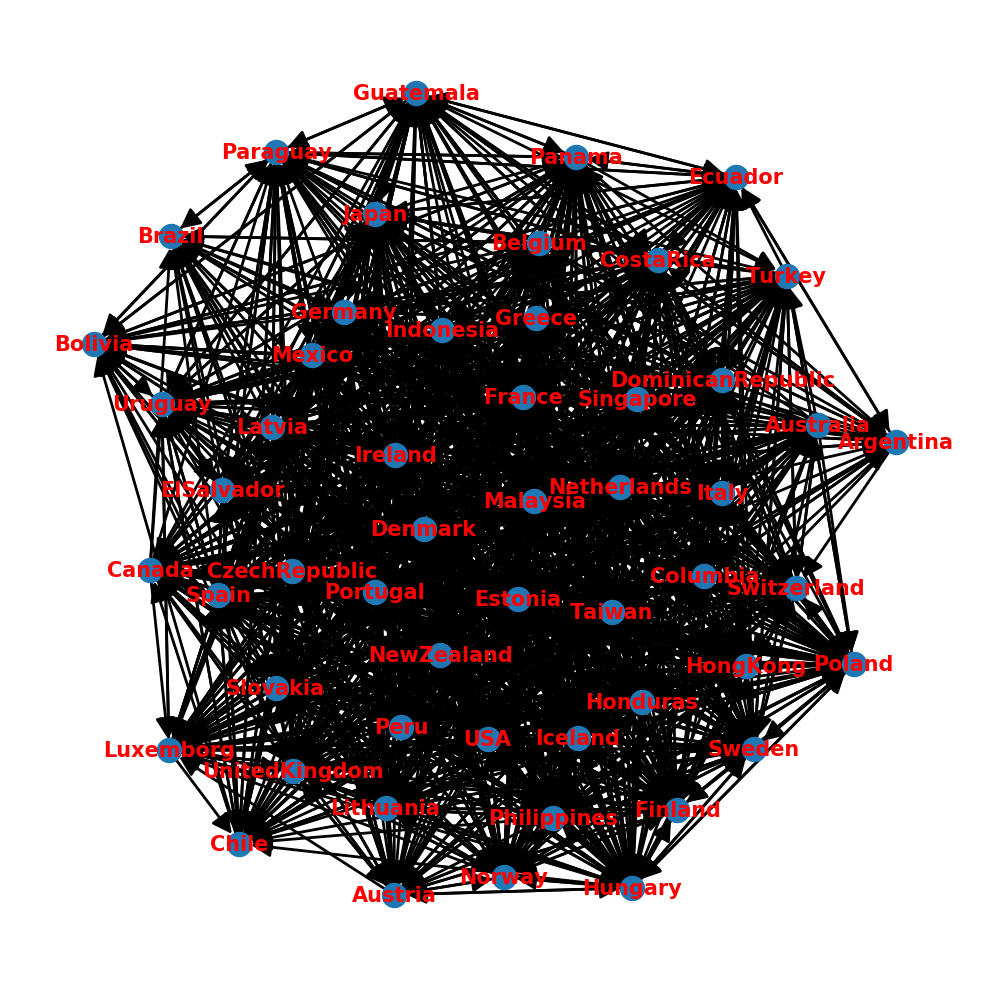

In [19]:
plot_graph(G_global)

## Extract patterns from graph

In [20]:
#[i for i in itertools.combinations([1,2,3,4,5], r=3)]

In [21]:
"""

min_size = 5
min_length= 3

final_paths_2= set()

edges_to_remove = [(u,v) for u,v,e in G_global.edges(data=True) if e['size'] < min_size]

G_global.remove_edges_from(edges_to_remove)

for song_set in tqdm(itertools.combinations(songs_in_graph, r=min_size)):
    G_target = G_global.copy()
    non_overlapping_edges =  [(u,v) for u,v,d in G_global.edges(data=True) 
                              if len(d['songs'].intersection(song_set)) < min_size]
    
    G_target.remove_edges_from(non_overlapping_edges)
    G_target.remove_nodes_from(list(nx.isolates(G_target)))
    
    paths= get_paths_from_graph(G_target)
    for p in paths:
        if len(p)>= min_length:   
            final_paths_2.add(tuple(p))
final_paths_2
"""

"\n\nmin_size = 5\nmin_length= 3\n\nfinal_paths_2= set()\n\nedges_to_remove = [(u,v) for u,v,e in G_global.edges(data=True) if e['size'] < min_size]\n\nG_global.remove_edges_from(edges_to_remove)\n\nfor song_set in tqdm(itertools.combinations(songs_in_graph, r=min_size)):\n    G_target = G_global.copy()\n    non_overlapping_edges =  [(u,v) for u,v,d in G_global.edges(data=True) \n                              if len(d['songs'].intersection(song_set)) < min_size]\n    \n    G_target.remove_edges_from(non_overlapping_edges)\n    G_target.remove_nodes_from(list(nx.isolates(G_target)))\n    \n    paths= get_paths_from_graph(G_target)\n    for p in paths:\n        if len(p)>= min_length:   \n            final_paths_2.add(tuple(p))\nfinal_paths_2\n"

In [22]:
"""
min_size = 5
min_length= 3

final_paths= {}

edges_to_remove = [(u,v) for u,v,e in G_global.edges(data=True) if e['size'] < min_size]

G_global.remove_edges_from(edges_to_remove)

for u_target, v_target, data_target in tqdm(G_global.edges(data=True)):
    #print('target',u_target, v_target)
    for i in range(min_size, 20):
        G_target = G_global.copy()
        non_overlapping_edges =  [(u,v) for u,v,d in G_global.edges(data=True) 
                                  if len(d['songs'].intersection(data_target['songs'])) != i]

        G_target.remove_edges_from(non_overlapping_edges)
        G_target.remove_nodes_from(list(nx.isolates(G_target)))

        paths= get_paths_from_graph(G_target)

        for p in paths:
            path_length = len(p)
            if path_length >= min_length:
                paths_with_length = final_paths.get(path_length, {})     
                t = paths_with_length.get(tuple(p),0)
                t += i 
                paths_with_length[tuple(p)]=t
                final_paths[path_length]=paths_with_length
"""

"\nmin_size = 5\nmin_length= 3\n\nfinal_paths= {}\n\nedges_to_remove = [(u,v) for u,v,e in G_global.edges(data=True) if e['size'] < min_size]\n\nG_global.remove_edges_from(edges_to_remove)\n\nfor u_target, v_target, data_target in tqdm(G_global.edges(data=True)):\n    #print('target',u_target, v_target)\n    for i in range(min_size, 20):\n        G_target = G_global.copy()\n        non_overlapping_edges =  [(u,v) for u,v,d in G_global.edges(data=True) \n                                  if len(d['songs'].intersection(data_target['songs'])) != i]\n\n        G_target.remove_edges_from(non_overlapping_edges)\n        G_target.remove_nodes_from(list(nx.isolates(G_target)))\n\n        paths= get_paths_from_graph(G_target)\n\n        for p in paths:\n            path_length = len(p)\n            if path_length >= min_length:\n                paths_with_length = final_paths.get(path_length, {})     \n                t = paths_with_length.get(tuple(p),0)\n                t += i \n             

In [23]:
def extract_patterns_from_graph(G, min_size, min_length):
    final_paths= {}
    visited_songs= set()

    edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if e['size'] < min_size]

    G.remove_edges_from(edges_to_remove)

    for u_target, v_target, data_target in tqdm(G.edges(data=True)):
        songs_to_visit = set()

        for i in range(min_size, len(data_target['songs'])):
            song_to_add = set()
            G_target = G.copy()
            edges_to_remove = []
            for u,v,d in G_target.edges(data=True):
                overlapped_songs= tuple(d['songs'].intersection(data_target['songs']))
                overlapped_songs_lngth= len(overlapped_songs)
                #print(overlapped_songs, overlapped_songs_lngth)
                if (overlapped_songs_lngth != i) or (overlapped_songs in visited_songs):
                    edges_to_remove.append((u,v))
                else:
                    songs_to_visit.add(overlapped_songs)
                    song_to_add.add(overlapped_songs)


            G_target.remove_edges_from(edges_to_remove)
            G_target.remove_nodes_from(list(nx.isolates(G_target)))

            paths= get_paths_from_graph(G_target)

            for p in paths:
                #print(p)
                path_length = len(p)
                if path_length >= min_length:
                    paths_with_length = final_paths.get(path_length, {})     
                    t = paths_with_length.get(tuple(p),set())
                    t = t.union(song_to_add) 
                    paths_with_length[tuple(p)]=t
                    final_paths[path_length]=paths_with_length
        visited_songs = visited_songs.union(songs_to_visit) 
    records = []
    for l, paths in final_paths.items():
        for p, songs in paths.items():
            records.append((l, p, len(songs)))
    paths_df= pd.DataFrame.from_records(records, columns='path_length path repetitions'.split())
    return paths_df

In [24]:
min_size = 5
min_length= 3
paths_df =extract_patterns_from_graph(G_global, min_size, min_length)

  0%|          | 0/856 [00:00<?, ?it/s]

In [25]:
paths_df.head()

,path_length,path,repetitions
0,3,"(Iceland, NewZealand, Norway)",12
1,3,"(Latvia, UnitedKingdom, Greece)",12
2,3,"(Latvia, Switzerland, Hungary)",12
3,3,"(Latvia, Switzerland, Slovakia)",12
4,3,"(USA, NewZealand, Iceland)",5


In [115]:
paths_df['path_length'].unique()

array([3, 4, 6, 7, 5], dtype=int64)

In [116]:
paths_df[paths_df['path_length']==3].sort_values('repetitions', ascending=False).values

array([[3, ('Lithuania', 'Norway', 'Denmark'), 40],
       [3, ('Iceland', 'Netherlands', 'Germany'), 25],
       [3, ('Lithuania', 'Norway', 'Ireland'), 24],
       [3, ('Lithuania', 'Norway', 'Poland'), 22],
       [3, ('Lithuania', 'Finland', 'Netherlands'), 22],
       [3, ('Lithuania', 'Greece', 'Ireland'), 20],
       [3, ('Lithuania', 'Norway', 'Switzerland'), 18],
       [3, ('Lithuania', 'Norway', 'Germany'), 17],
       [3, ('Lithuania', 'Finland', 'Portugal'), 17],
       [3, ('Lithuania', 'Greece', 'Denmark'), 17],
       [3, ('Greece', 'Denmark', 'Switzerland'), 17],
       [3, ('Finland', 'Netherlands', 'Poland'), 17],
       [3, ('Estonia', 'Norway', 'UnitedKingdom'), 16],
       [3, ('Estonia', 'Norway', 'Finland'), 16],
       [3, ('Lithuania', 'Norway', 'Spain'), 15],
       [3, ('Latvia', 'Denmark', 'UnitedKingdom'), 14],
       [3, ('Latvia', 'Sweden', 'CzechRepublic'), 14],
       [3, ('Latvia', 'Denmark', 'Germany'), 14],
       [3, ('Lithuania', 'Norway', 'Portug

In [117]:
paths_df[paths_df['path_length']==4].sort_values('repetitions', ascending=False).values

array([[4, ('Norway', 'Estonia', 'Denmark', 'UnitedKingdom'), 14],
       [4, ('Norway', 'Estonia', 'Denmark', 'Germany'), 14],
       [4, ('Netherlands', 'Estonia', 'Denmark', 'UnitedKingdom'), 14],
       [4, ('Netherlands', 'Estonia', 'Denmark', 'Germany'), 14],
       [4, ('Sweden', 'Finland', 'Denmark', 'Germany'), 13],
       [4, ('Norway', 'UnitedKingdom', 'Netherlands', 'Germany'), 13],
       [4, ('Norway', 'Finland', 'Denmark', 'Germany'), 13],
       [4, ('Finland', 'Sweden', 'Greece', 'CzechRepublic'), 12],
       [4, ('Finland', 'Sweden', 'Greece', 'Switzerland'), 12],
       [4, ('Lithuania', 'Estonia', 'Netherlands', 'UnitedKingdom'), 12],
       [4, ('Lithuania', 'Estonia', 'Netherlands', 'Switzerland'), 12],
       [4, ('Lithuania', 'Estonia', 'Netherlands', 'Germany'), 12],
       [4, ('Lithuania', 'Norway', 'Denmark', 'Switzerland'), 11],
       [4, ('Lithuania', 'Latvia', 'Netherlands', 'Poland'), 11],
       [4, ('Finland', 'Estonia', 'Sweden', 'Denmark'), 7],
    

In [118]:
paths_df[paths_df['path_length']==5].sort_values('repetitions', ascending=False).values

array([[5, ('Sweden', 'Netherlands', 'Latvia', 'Greece', 'Denmark'), 12],
       [5, ('Lithuania', 'Norway', 'Finland', 'Netherlands', 'Poland'),
        11],
       [5, ('Lithuania', 'Norway', 'Latvia', 'Netherlands', 'Poland'),
        11],
       [5, ('Lithuania', 'Estonia', 'Norway', 'Netherlands', 'Spain'), 4]],
      dtype=object)

In [119]:
paths_df[paths_df['path_length']==6].sort_values('repetitions', ascending=False).head(10).values

array([[6,
        ('Greece', 'Ireland', 'UnitedKingdom', 'Estonia', 'Netherlands', 'Poland'),
        17],
       [6,
        ('Sweden', 'Ireland', 'UnitedKingdom', 'Estonia', 'Netherlands', 'Poland'),
        17]], dtype=object)

In [120]:
paths_df[paths_df['path_length']==7].sort_values('repetitions', ascending=False).head(10).values

array([[7,
        ('Greece', 'Ireland', 'UnitedKingdom', 'Estonia', 'Norway', 'Netherlands', 'Poland'),
        17],
       [7,
        ('Sweden', 'Ireland', 'UnitedKingdom', 'Estonia', 'Norway', 'Netherlands', 'Poland'),
        17]], dtype=object)

### Patterns by gender

In [130]:
min_size = 2
min_length= 3
for g, G_g in G_genres.items():
    path_df =extract_patterns_from_graph(G_g, min_size, min_length)
    print(g, 3, path_df[path_df['path_length']==3].sort_values('repetitions', ascending=False).head(10).values)
    print(g, 4, path_df[path_df['path_length']==4].sort_values('repetitions', ascending=False).head(10).values)

  0%|          | 0/446 [00:00<?, ?it/s]

pop 3 [[3 ('Sweden', 'Greece', 'CzechRepublic') 59]
 [3 ('Finland', 'Netherlands', 'Germany') 44]
 [3 ('Estonia', 'Norway', 'Poland') 42]
 [3 ('Lithuania', 'Estonia', 'Malaysia') 42]
 [3 ('Lithuania', 'Netherlands', 'UnitedKingdom') 40]
 [3 ('Greece', 'Norway', 'Poland') 38]
 [3 ('Estonia', 'Singapore', 'Philippines') 37]
 [3 ('Estonia', 'Netherlands', 'Denmark') 34]
 [3 ('Switzerland', 'Singapore', 'USA') 33]
 [3 ('Finland', 'Norway', 'Poland') 32]]
pop 4 [[4 ('Estonia', 'Norway', 'Sweden', 'Portugal') 39]
 [4 ('Finland', 'Norway', 'Latvia', 'Netherlands') 39]
 [4 ('Finland', 'Norway', 'Netherlands', 'Germany') 37]
 [4 ('Lithuania', 'Norway', 'Denmark', 'Germany') 31]
 [4 ('Lithuania', 'Estonia', 'Denmark', 'CzechRepublic') 30]
 [4 ('Lithuania', 'Finland', 'Iceland', 'CzechRepublic') 30]
 [4 ('Ireland', 'Singapore', 'UnitedKingdom', 'NewZealand') 29]
 [4 ('Canada', 'Iceland', 'Latvia', 'Greece') 29]
 [4 ('Ireland', 'Latvia', 'Switzerland', 'HongKong') 29]
 [4 ('Ireland', 'USA', 'Hunga

  0%|          | 0/168 [00:00<?, ?it/s]

hip-hop 3 [[3 ('Iceland', 'UnitedKingdom', 'Sweden') 23]
 [3 ('DominicanRepublic', 'Honduras', 'Ecuador') 23]
 [3 ('Ireland', 'UnitedKingdom', 'Sweden') 21]
 [3 ('DominicanRepublic', 'Chile', 'Panama') 18]
 [3 ('Denmark', 'Switzerland', 'Germany') 15]
 [3 ('Hungary', 'Switzerland', 'Germany') 15]
 [3 ('DominicanRepublic', 'Honduras', 'ElSalvador') 15]
 [3 ('DominicanRepublic', 'Spain', 'Ecuador') 14]
 [3 ('Chile', 'Uruguay', 'Peru') 12]
 [3 ('Uruguay', 'Spain', 'ElSalvador') 11]]
hip-hop 4 [[4 ('Iceland', 'UnitedKingdom', 'Greece', 'CzechRepublic') 15]
 [4 ('Finland', 'Latvia', 'Slovakia', 'CzechRepublic') 15]
 [4 ('Honduras', 'Paraguay', 'Peru', 'Ecuador') 13]
 [4 ('Uruguay', 'Spain', 'Peru', 'Honduras') 11]
 [4 ('Uruguay', 'Ecuador', 'Peru', 'Honduras') 11]
 [4 ('Greece', 'Hungary', 'Ireland', 'UnitedKingdom') 9]
 [4 ('Honduras', 'Paraguay', 'Chile', 'Peru') 9]
 [4 ('NewZealand', 'Iceland', 'UnitedKingdom', 'Greece') 9]
 [4 ('NewZealand', 'Iceland', 'UnitedKingdom', 'Norway') 9]
 [4 

  0%|          | 0/9 [00:00<?, ?it/s]

folk/traditional 3 []
folk/traditional 4 []


  0%|          | 0/12 [00:00<?, ?it/s]

electronic 3 []
electronic 4 []


  0%|          | 0/17 [00:00<?, ?it/s]

rythm and blues 3 []
rythm and blues 4 []


  0%|          | 0/7 [00:00<?, ?it/s]

rock 3 []
rock 4 []


  0%|          | 0/14 [00:00<?, ?it/s]

indie 3 []
indie 4 []


0it [00:00, ?it/s]

classical and ost 3 []
classical and ost 4 []


  0%|          | 0/150 [00:00<?, ?it/s]

latin 3 [[3 ('DominicanRepublic', 'Chile', 'Guatemala') 30]
 [3 ('Paraguay', 'Peru', 'CostaRica') 29]
 [3 ('DominicanRepublic', 'Honduras', 'Guatemala') 28]
 [3 ('Spain', 'Paraguay', 'Guatemala') 26]
 [3 ('Columbia', 'Panama', 'ElSalvador') 23]
 [3 ('Columbia', 'Panama', 'Uruguay') 21]
 [3 ('Uruguay', 'Peru', 'ElSalvador') 20]
 [3 ('DominicanRepublic', 'Honduras', 'ElSalvador') 20]
 [3 ('Ecuador', 'Uruguay', 'Guatemala') 20]
 [3 ('DominicanRepublic', 'Paraguay', 'Guatemala') 20]]
latin 4 [[4 ('Paraguay', 'Chile', 'Columbia', 'Guatemala') 22]
 [4 ('Paraguay', 'Chile', 'DominicanRepublic', 'Guatemala') 22]
 [4 ('Paraguay', 'Peru', 'Uruguay', 'Guatemala') 22]
 [4 ('Paraguay', 'Chile', 'Panama', 'Guatemala') 22]
 [4 ('Paraguay', 'Chile', 'Honduras', 'Guatemala') 22]
 [4 ('Ecuador', 'Uruguay', 'Paraguay', 'Guatemala') 20]
 [4 ('Chile', 'DominicanRepublic', 'Panama', 'ElSalvador') 17]
 [4 ('Uruguay', 'Paraguay', 'Peru', 'CostaRica') 17]
 [4 ('Chile', 'DominicanRepublic', 'Panama', 'Uruguay')

0it [00:00, ?it/s]

miscellaneous 3 []
miscellaneous 4 []


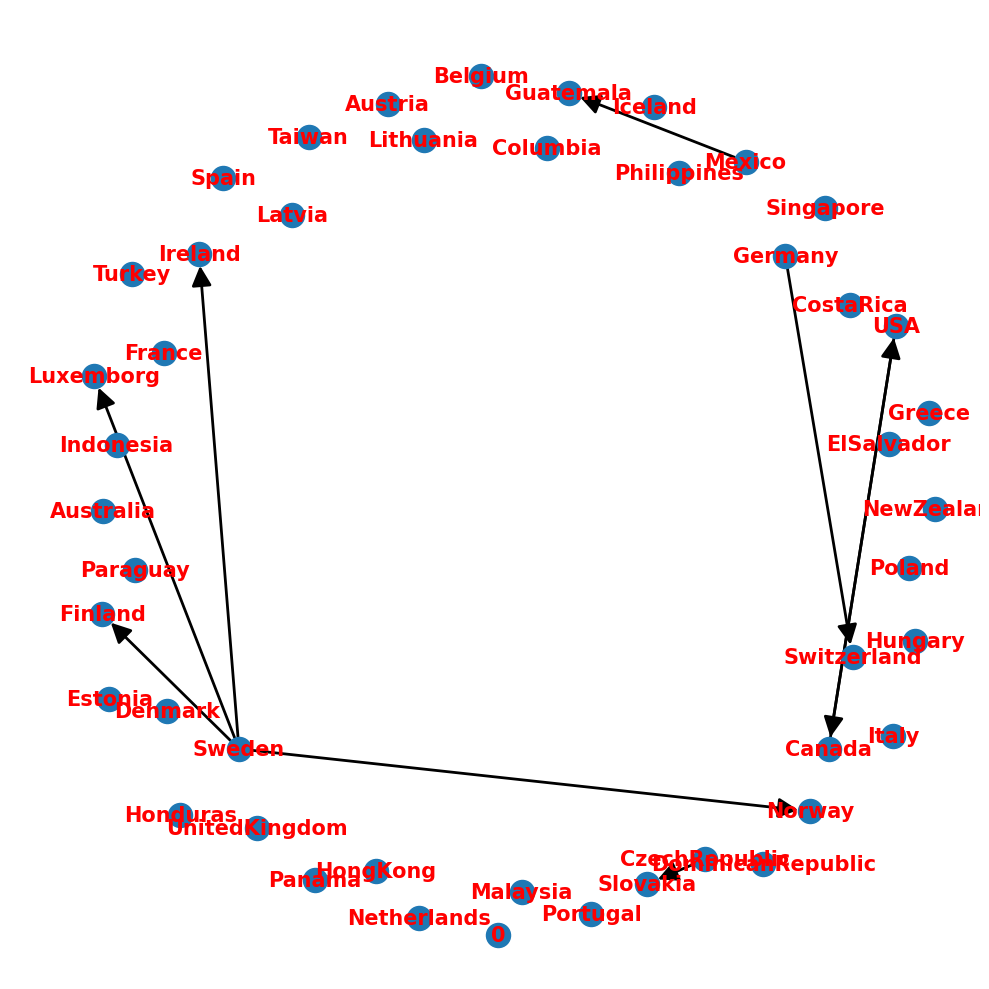

In [131]:
plot_graph(G_genres['folk/traditional'])

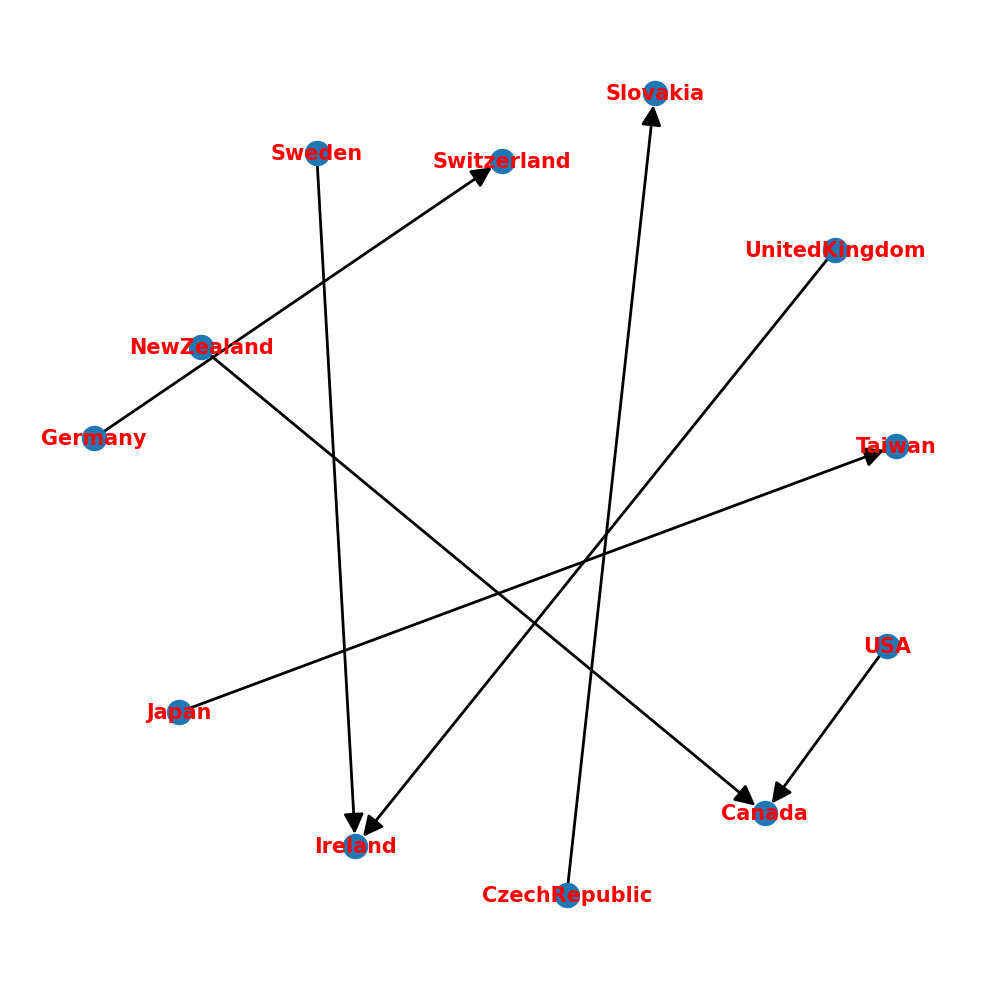

In [137]:
plot_graph(G_genres['rock'])

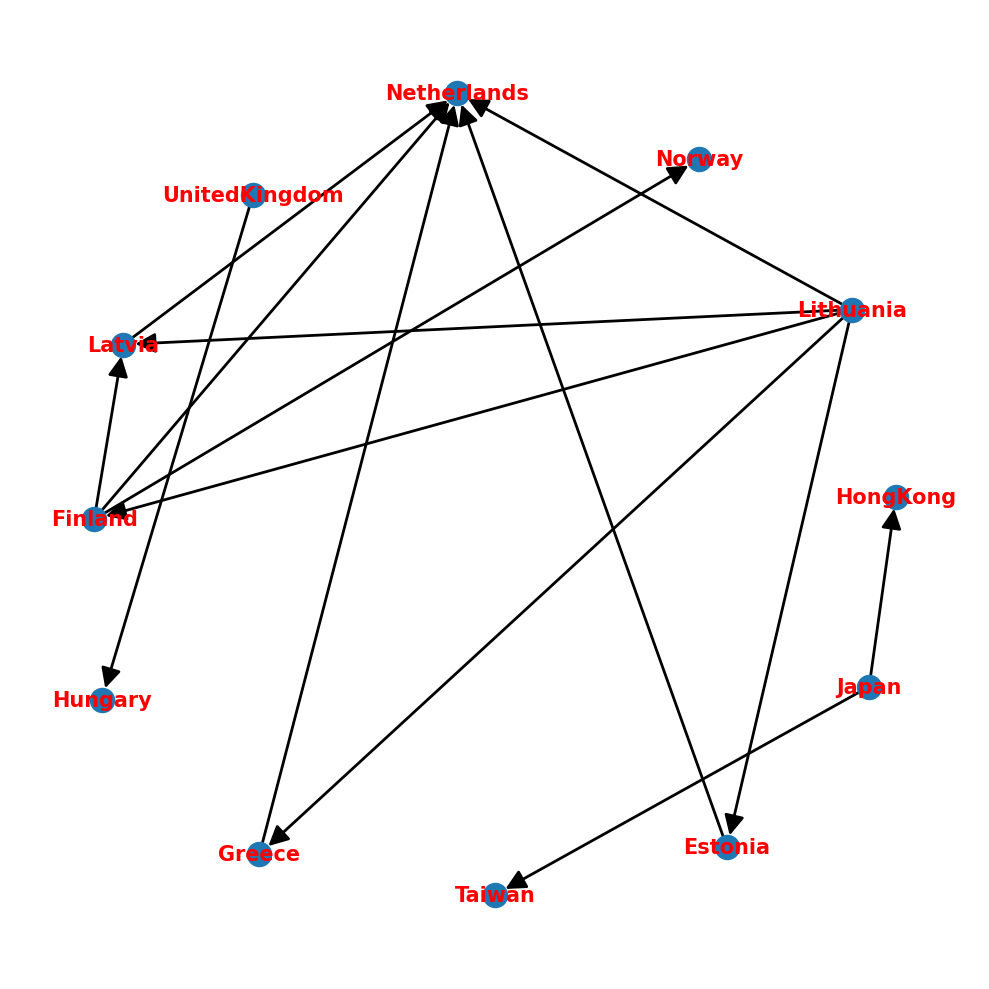

In [136]:
plot_graph(G_genres['indie'])

In [122]:
print("That's all folks!")

That's all folks!
